In [ ]:
!pip list
!nvidia-smi
!nvcc --version

Package                            Version
---------------------------------- ------------------
absl-py                            1.4.0
accelerate                         1.3.0
aiohappyeyeballs                   2.4.6
aiohttp                            3.11.13
aiosignal                          1.3.2
alabaster                          1.0.0
albucore                           0.0.23
albumentations                     2.0.5
ale-py                             0.10.2
altair                             5.5.0
annotated-types                    0.7.0
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.6.0
arviz                              0.20.0
astropy                            7.0.1
astropy-iers-data                  0.2025.3.3.0.34.45
astunparse                         1.6.3
atpublic                           4.1.0
attrs                              25.1.0
audioread            

## ***PAKET KURULUMLARI***

In [ ]:
print("Attempting to update core libraries to known compatible versions...")

!pip uninstall -y trl
!pip uninstall -y transformers
!pip uninstall -y peft
!pip uninstall -y accelerate


print("\nInstalling specific versions of TRL, Transformers, PEFT, and Accelerate...")
# SFTTrainer'ın modern API'si için bilinen iyi bir TRL sürümü (örn: 0.9.3)
# ve onunla uyumlu diğer kütüphane sürümlerini hedefleyelim.
# Transformers için 4.38.0 ve üzeri genellikle TRL 0.8.x/0.9.x ile iyi çalışır.
# PEFT için 0.9.0 ve üzeri.
!pip install -q transformers>=4.38.0
!pip install -q peft>=0.9.0
!pip install -q trl==0.9.3 # <<<--- ÖNEMLİ: Spesifik ve daha yeni bir TRL sürümü
!pip install -q accelerate>=0.25.0 # Accelerate için de makul bir alt sınır
!pip install -q datasets bitsandbytes

print("\n--- Verifying Installed Package Versions After Update ---")
import torch
import trl
import transformers
import peft
import accelerate
import datasets
# bitsandbytes versiyonu için pip show
!pip show bitsandbytes | grep Version

print(f"PyTorch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"CUDA available. PyTorch CUDA version: {torch.version.cuda}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is NOT available.")
print(f"TRL version: {trl.__version__} (Expected >= 0.8.0)")
print(f"Transformers version: {transformers.__version__} (Expected >= 4.38.0)")
print(f"PEFT version: {peft.__version__} (Expected >= 0.9.0)")
print(f"Accelerate version: {accelerate.__version__} (Expected >= 0.25.0)")
print(f"Datasets version: {datasets.__version__}")

print("\n***** ÖNEMLİ: Paket kurulumları/güncellemeleri tamamlandı. *****")
print("***** LÜTFEN 'Çalışma Zamanı -> Çalışma zamanını yeniden başlat' seçeneğini kullanarak *****")
print("***** ÇALIŞMA ZAMANINI ŞİMDİ YENİDEN BAŞLATIN. *****")
print("***** Yeniden başlattıktan sonra BU HÜCREYİ TEKRAR ÇALIŞTIRMAYIN. *****")
print("***** Diğer hücrelerle (importlar, Drive bağlantısı, model yükleme vb.) devam edin. *****")

Attempting to update core libraries to known compatible versions...
Found existing installation: trl 0.7.10
Uninstalling trl-0.7.10:
  Successfully uninstalled trl-0.7.10
Found existing installation: transformers 4.51.3
Uninstalling transformers-4.51.3:
  Successfully uninstalled transformers-4.51.3
Found existing installation: peft 0.15.2
Uninstalling peft-0.15.2:
  Successfully uninstalled peft-0.15.2
Found existing installation: accelerate 1.7.0
Uninstalling accelerate-1.7.0:
  Successfully uninstalled accelerate-1.7.0

Installing specific versions of TRL, Transformers, PEFT, and Accelerate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.6/226.6 kB 15.2 MB/s eta 0:00:00

--- Verifying Installed Package Versions After Update ---
Version: 0.45.5
PyTorch version: 2.5.1+cu124
CUDA available. PyTorch CUDA version: 12.4
GPU Name: NVIDIA A100-SXM4-40GB
TRL version: 0.9.3 (Expected >= 0.8.0)
Transformers version: 4.51.3 (Expected >= 4.38.0)
PEFT version: 0.15.2 (Expected >= 0.9.0)
Accele

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

# ***TEMEL IMPORTLAR VE AYARLAR***

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
from tqdm.auto import tqdm # tqdm.auto kullanmak daha iyi
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
# from trl import setup_chat_format # Eğer chat formatlaması kullanılıyorsa, modern trl'de bu farklı olabilir
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging as hf_logging # logging adıyla çakışmaması için
)
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from huggingface_hub import login, HfFolder

# Uyarıları bastır
warnings.filterwarnings("ignore")
hf_logging.set_verbosity_error() # Transformers loglarını azalt

# Ortam değişkenleri
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false" # Genellikle iyi bir ayar

# Cihazı belirle
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Working on device: {device}")

# PyTorch backend ayarları (notebook'taki gibi)
if torch.cuda.is_available(): # Sadece CUDA varsa bu ayarları yap
    torch.backends.cuda.enable_mem_efficient_sdp(False)
    torch.backends.cuda.enable_flash_sdp(False)

# Google Drive'a bağlan
try:
    drive.mount('/content/drive', force_remount=True)
    print("Google Drive bağlandı.")
except Exception as e:
    print(f"Google Drive bağlantı hatası: {e}")

HF_TOKEN = "---" # KENDİ TOKEN'INI YAPIŞTIR

if HF_TOKEN and HF_TOKEN != "---":
    try:
        login(token=HF_TOKEN, add_to_git_credential=True)
        print("Hugging Face girişi başarılı (token ile).")
    except Exception as e:
        print(f"Hugging Face token ile giriş hatası: {e}")
        print("Lütfen geçerli bir token girdiğinizden emin olun.")
else:
    print("UYARI: Hugging Face token girilmemiş. Model indirme işlemi başarısız olabilir.")
    print("Lütfen yukarıdaki HF_TOKEN değişkenine geçerli bir token girin veya notebook_login() kullanın.")

Working on device: cuda:0
Mounted at /content/drive
Google Drive bağlandı.
UYARI: Hugging Face token girilmemiş. Model indirme işlemi başarısız olabilir.
Lütfen yukarıdaki HF_TOKEN değişkenine geçerli bir token girin veya notebook_login() kullanın.


# ***MODEL YÖNETİMİ***

In [ ]:
import os
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

# --- Konfigürasyon ---
model_id_hf = "meta-llama/Meta-Llama-3-8B-Instruct"
# Modeli Drive'da saklamak istediğin klasör yolu (kendi Drive yapına göre düzenle)
drive_base_path = "/content/drive/MyDrive/AI_Models" # Ana model klasörün
model_folder_name = "Llama3_8B_Instruct_HF" # Modelin alt klasör adı
drive_model_path = os.path.join(drive_base_path, model_folder_name)

#kontrol
model_config_path_in_drive = os.path.join(drive_model_path, "config.json")
model_exists_in_drive = os.path.exists(model_config_path_in_drive)

# Global model ve tokenizer değişkenleri
model = None
tokenizer = None

if not model_exists_in_drive:
    print(f"Model '{drive_model_path}' adresinde bulunamadı.")
    print(f"Hugging Face'den '{model_id_hf}' modeli indiriliyor ve Drive'a kaydediliyor...")
    os.makedirs(drive_model_path, exist_ok=True)

    try:
        # Modeli ve tokenizer'ı indir (quantization olmadan, orijinal dosyalar)
        print(f"'{model_id_hf}' model dosyaları indiriliyor...")
        temp_model = AutoModelForCausalLM.from_pretrained(model_id_hf) # Token burada otomatik kullanılır (eğer login yapıldıysa)
        print(f"'{model_id_hf}' tokenizer dosyaları indiriliyor...")
        temp_tokenizer = AutoTokenizer.from_pretrained(model_id_hf)

        print(f"İndirilen model ve tokenizer '{drive_model_path}' adresine kaydediliyor...")
        temp_model.save_pretrained(drive_model_path)
        temp_tokenizer.save_pretrained(drive_model_path)
        print("Model ve tokenizer Drive'a başarıyla kaydedildi.")
        del temp_model # Hafızayı boşalt
        del temp_tokenizer
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        model_exists_in_drive = True # Artık Drive'da var
    except Exception as e:
        print(f"Model indirme veya Drive'a kaydetme sırasında HATA: {e}")
        print("Lütfen Hugging Face token'ınızın geçerli olduğundan ve Llama 3 modeline erişim izniniz olduğundan emin olun.")
        # Bu durumda notebook'u durdurabilir veya hatayı yükseltebiliriz.
        raise RuntimeError("Model indirilemedi, devam edilemiyor.") from e
else:
    print(f"Model zaten '{drive_model_path}' adresinde mevcut.")

# Modeli (ve tokenizer'ı) Drive'dan yükle (artık Drive'da olmalı)
if model_exists_in_drive:
    print(f"\nModel '{drive_model_path}' adresinden yükleniyor...")
    compute_dtype = getattr(torch, "float16")
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=False,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=compute_dtype,
    )
    try:
        model = AutoModelForCausalLM.from_pretrained(
            drive_model_path, # Yerel (Drive) yoldan yüklüyoruz
            quantization_config=bnb_config,
            torch_dtype=compute_dtype,
            device_map="auto" # "auto" veya device
        )
        print("Model Drive'dan başarıyla yüklendi.")

        model.config.use_cache = False # Fine-tuning için önemli
        # model.config.pretraining_tp = 1 # Genellikle Llama 3 için gerekmez, sorun olursa açılabilir

        tokenizer = AutoTokenizer.from_pretrained(drive_model_path)
        if tokenizer.pad_token is None:
            # Llama 3 modellerinde pad_token genelde eos_token ile aynıdır veya ayarlanması gerekir.
            tokenizer.pad_token = tokenizer.eos_token

        print("Tokenizer Drive'dan başarıyla yüklendi.")
        print(f"Tokenizer Pad Token: {tokenizer.pad_token} (ID: {tokenizer.pad_token_id})")
        print(f"Tokenizer EOS Token: {tokenizer.eos_token} (ID: {tokenizer.eos_token_id})")


    except Exception as e:
        print(f"Model veya tokenizer Drive'dan yüklenirken HATA: {e}")
        raise RuntimeError("Model/Tokenizer Drive'dan yüklenemedi.") from e
else:
    print("HATA: Model Drive'da bulunamadı ve indirilemedi. Notebook devam edemez.")

# max_seq_length'i burada tanımla (notebook'un orijinalindeki gibi)
if model and tokenizer: # Model ve tokenizer başarıyla yüklendiyse
    max_seq_length = 512
    print(f"max_seq_length set to: {max_seq_length}")
else:
    print("Model veya tokenizer yüklenemediği için max_seq_length ayarlanamadı.")

Model zaten '/content/drive/MyDrive/AI_Models/Llama3_8B_Instruct_HF' adresinde mevcut.

Model '/content/drive/MyDrive/AI_Models/Llama3_8B_Instruct_HF' adresinden yükleniyor...


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

Model Drive'dan başarıyla yüklendi.
Tokenizer Drive'dan başarıyla yüklendi.
Tokenizer Pad Token: <|eot_id|> (ID: 128009)
Tokenizer EOS Token: <|eot_id|> (ID: 128009)
max_seq_length set to: 512


In [ ]:
filename = "/content/drive/MyDrive/FT/FineTuningData/data.csv" # Drive'daki kendi yoluna göre düzelt!

df = pd.read_csv(filename,
                 encoding="utf-8", encoding_errors="replace")
df.columns = ["text", "sentiment"]
df.head()

,text,sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [ ]:
# Eğitim ve test verileri için boş listeler oluşturuluyor
X_train = list()
X_test = list()

# Her bir duygu sınıfı (pozitif, nötr, negatif) için döngü başlatılıyor
for sentiment in ["positive", "neutral", "negative"]:
    # Mevcut duygu sınıfına ait veriler filtreleniyor
    # Bu filtrelenmiş veriden, belirtilen boyutlarda eğitim ve test setleri ayrılıyor
    # random_state: Tekrarlanabilirlik için rastgelelik tohumu
    train, test  = train_test_split(df[df.sentiment==sentiment],  # df: ana veri çerçevesi
                                    train_size=300,              # Her sınıftan eğitim için 300 örnek
                                    test_size=300,               # Her sınıftan test için 300 örnek
                                    random_state=42)             # Rastgelelik için sabit bir değer
    # Ayrılan eğitim verisi X_train listesine ekleniyor
    X_train.append(train)
    # Ayrılan test verisi X_test listesine ekleniyor
    X_test.append(test)

# Farklı duygu sınıflarından gelen eğitim verileri birleştiriliyor
# frac=1: Tüm veriyi al, random_state=10: Karıştırma işlemi için rastgelelik tohumu
X_train = pd.concat(X_train).sample(frac=1, random_state=10)

# Farklı duygu sınıflarından gelen test verileri birleştiriliyor
X_test = pd.concat(X_test)


# Değerlendirme seti için kullanılacak indeksler belirleniyor:
# Ana veri çerçevesindeki (df) indekslerden, eğitim (X_train) ve test (X_test)
# setlerine dahil olmayanlar seçiliyor.
eval_idx = [idx for idx in df.index if idx not in list(X_train.index) + list(X_test.index)]

# Değerlendirme seti (X_eval), belirlenen indekslere sahip verilerden oluşturuluyor
X_eval = df[df.index.isin(eval_idx)]

# Değerlendirme setindeki her duygu sınıfından rastgele 50'şer örnek seçiliyor
# replace=True: Aynı örneğin birden fazla kez seçilebilmesini sağlar (eğer bir sınıfta 50'den az örnek varsa)
X_eval = (X_eval
          .groupby('sentiment', group_keys=False)  # Duyguya göre grupla, grup anahtarlarını indekse ekleme
          .apply(lambda x: x.sample(n=50, random_state=10, replace=True))) # Her gruptan 50 örnek al

# Eğitim setinin indeksi sıfırlanıyor ve eski indeks sütunu (varsa) kaldırılıyor
X_train = X_train.reset_index(drop=True)

In [ ]:
X_train.shape, X_eval.shape, X_test.shape


((900, 2), (150, 2), (900, 2))

In [ ]:
def generate_prompt(data_point):
    return f"""
            Analyze the sentiment of the news headline enclosed in square brackets,
            determine if it is positive, neutral, or negative, and return the answer as
            the corresponding sentiment label "positive" or "neutral" or "negative".

            [{data_point["text"]}] = {data_point["sentiment"]}
            """.strip()

def generate_test_prompt(data_point):
    return f"""
            Analyze the sentiment of the news headline enclosed in square brackets,
            determine if it is positive, neutral, or negative, and return the answer as
            the corresponding sentiment label "positive" or "neutral" or "negative".

            [{data_point["text"]}] = """.strip()

In [ ]:
# Eğitim verisindeki her satıra prompt oluşturan fonksiyon (örneğin: "Soru: ... Cevap: ...") uygulanır
# Sonuçlar "text" isimli bir sütunla DataFrame'e dönüştürülür
X_train = pd.DataFrame(X_train.apply(generate_prompt, axis=1), columns=["text"])

# Değerlendirme verisine de aynı şekilde prompt uygulanır
X_eval = pd.DataFrame(X_eval.apply(generate_prompt, axis=1), columns=["text"])

# Gerçek etiketler ayrı bir değişkende saklanır (modelin tahminleriyle karşılaştırmak için)
y_true = X_test.sentiment

# Test verisine özel prompt (muhtemelen içinde cevap yok, sadece soru ya da bağlam) uygulanır
X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis=1), columns=["text"])

# Hugging Face Dataset formatına dönüştürülür (Trainer veya SFTConfig ile uyumlu hale gelir)
train_data = Dataset.from_pandas(X_train)
eval_data = Dataset.from_pandas(X_eval)


In [ ]:
def evaluate(y_true, y_pred):
    labels = ['positive', 'neutral', 'negative']
    mapping = {'positive': 2, 'neutral': 1, 'none':1, 'negative': 0}
    def map_func(x):
        return mapping.get(x, 1)

    y_true = np.vectorize(map_func)(y_true)
    y_pred = np.vectorize(map_func)(y_pred)

    # Class labels
    class_labels = ['negative', 'neutral', 'positive']

    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    print(f'Accuracy: {accuracy:.3f}')

    # Generate accuracy report
    unique_labels = set(y_true)  # Get unique labels

    for label in unique_labels:
        label_indices = [i for i in range(len(y_true))
                         if y_true[i] == label]
        label_y_true = [y_true[i] for i in label_indices]
        label_y_pred = [y_pred[i] for i in label_indices]
        accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {label}: {accuracy:.3f}')

    # Generate classification report
    class_report = classification_report(y_true=y_true, y_pred=y_pred, target_names=class_labels)
    print('\nClassification Report:')
    print(class_report)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0, 1, 2])
    print('\nConfusion Matrix:')
    print(conf_matrix)

    # Create a heatmap
    plt.figure(figsize=(6, 5))

    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Oranges", xticklabels=class_labels, yticklabels=class_labels)

    # Add labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

## ***TESTİNG LLAMA***

In [ ]:
import os
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
drive_base_path = "/content/drive/MyDrive/AI_Models" # Ana model klasörün (bir önceki cevaptaki gibi)
model_folder_name = "Llama3_8B_Instruct_HF"        # Modelin alt klasör adı (bir önceki cevaptaki gibi)
model_path_from_drive = os.path.join(drive_base_path, model_folder_name)
print(f"Modelin Drive'daki beklenen yolu: {model_path_from_drive}")

# Modelin Drive'da olup olmadığını kontrol et
model_config_path_in_drive = os.path.join(model_path_from_drive, "config.json")
if not os.path.exists(model_config_path_in_drive):
    print(f"HATA: Model '{model_path_from_drive}' adresinde bulunamıyor!")
    print("Lütfen modeli önce Drive'a indirdiğinizden/kaydettiğinizden emin olun.")
    print("Bir önceki 'Modeli İndir ve Drive'a Kaydet' adımını kontrol edin.")
    raise FileNotFoundError(f"Model config not found at {model_config_path_in_drive}")

# 2. device değişkeninin tanımlı olduğundan emin ol (notebook'un başında veya önceki bir hücrede olmalı)
if 'device' not in locals():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 3. Quantization ve diğer ayarlar (notebook'undaki gibi)
compute_dtype = getattr(torch, "float16")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
)

print(f"Loading model from Google Drive: {model_path_from_drive}...")
try:
    model = AutoModelForCausalLM.from_pretrained(
        model_path_from_drive,
        quantization_config=bnb_config,
        torch_dtype=compute_dtype,
        device_map="auto"
    )
    print("Model loaded successfully from Drive.")
except Exception as e:
    print(f"Error loading model from Drive: {e}")
    raise

# 5. Model konfigürasyonları
if 'model' in locals():
    model.config.use_cache = False
    # model.config.pretraining_tp = 1 # Genellikle Llama 3 için gerekmez

    print(f"Loading tokenizer from Google Drive: {model_path_from_drive}...")
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_path_from_drive)

        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

        print("Tokenizer loaded successfully from Drive.")
        print(f"Tokenizer pad token: {tokenizer.pad_token}, pad_token_id: {tokenizer.pad_token_id}")
        print(f"Tokenizer eos token: {tokenizer.eos_token}, eos_token_id: {tokenizer.eos_token_id}")
        print(f"Tokenizer model_max_length: {tokenizer.model_max_length}")


        max_seq_length = 512
        print(f"max_seq_length (for training/SFTTrainer) set to: {max_seq_length}")

    except Exception as e:
        print(f"Error loading tokenizer from Drive: {e}")
        raise
else:
    print("Model could not be loaded. Tokenizer and further steps will be skipped.")

Modelin Drive'daki beklenen yolu: /content/drive/MyDrive/AI_Models/Llama3_8B_Instruct_HF
Using device: cuda:0
Loading model from Google Drive: /content/drive/MyDrive/AI_Models/Llama3_8B_Instruct_HF...


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

Model loaded successfully from Drive.
Loading tokenizer from Google Drive: /content/drive/MyDrive/AI_Models/Llama3_8B_Instruct_HF...
Tokenizer loaded successfully from Drive.
Tokenizer pad token: <|eot_id|>, pad_token_id: 128009
Tokenizer eos token: <|eot_id|>, eos_token_id: 128009
Tokenizer model_max_length: 1000000000000000019884624838656
max_seq_length (for training/SFTTrainer) set to: 512


In [ ]:
def predict(test, model, tokenizer):

    y_pred = []

    for i in tqdm(range(len(X_test))):
        prompt = X_test.iloc[i]["text"]
        pipe = pipeline(
            task="text-generation",
            model=model,
            tokenizer=tokenizer,
            max_new_tokens=1,
            do_sample=False,

        )
        result = pipe(prompt)
        full_generated_text = result[0]['generated_text']

        if "=" in full_generated_text:
            answer_part = full_generated_text.split("=")[-1]
        else:


        answer = answer_part.strip().lower()



        if "positive" in answer:
            y_pred.append("positive")
        elif "negative" in answer:
            y_pred.append("negative")
        elif "neutral" in answer:
            y_pred.append("neutral")
        else:
            y_pred.append("none")

    return y_pred

In [ ]:
y_pred = predict(test, model, tokenizer)

  0%|          | 0/900 [00:00<?, ?it/s]

## ***İnce Ayar Öncesi Model Testi***

Accuracy: 0.434
Accuracy for label 0: 0.107
Accuracy for label 1: 0.990
Accuracy for label 2: 0.207

Classification Report:
              precision    recall  f1-score   support

    negative       0.91      0.11      0.19       300
     neutral       0.37      0.99      0.54       300
    positive       0.91      0.21      0.34       300

    accuracy                           0.43       900
   macro avg       0.73      0.43      0.36       900
weighted avg       0.73      0.43      0.36       900


Confusion Matrix:
[[ 32 265   3]
 [  0 297   3]
 [  3 235  62]]


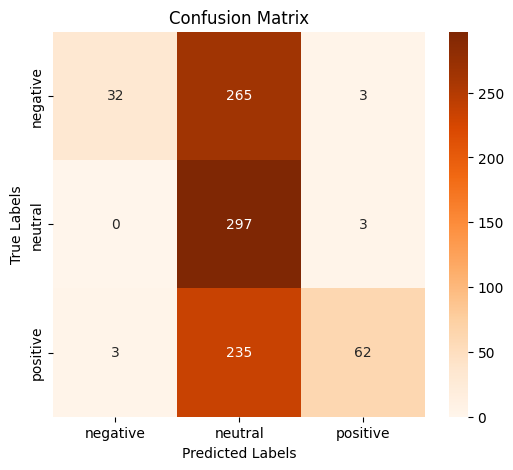

In [ ]:
evaluate(y_true, y_pred)


# ***Fine-tuning***

In [ ]:
from sklearn.metrics import (accuracy_score,
                             recall_score,
                             precision_score,
                             f1_score)

from transformers import EarlyStoppingCallback, IntervalStrategy

def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
!pip install -q trl==0.7.10

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 4.9 MB/s eta 0:00:00


In [ ]:
import trl
print(trl.__version__)


0.9.3


In [ ]:
from peft import LoraConfig
from transformers import AutoTokenizer, AutoModelForCausalLM
from trl import SFTConfig, SFTTrainer

# 1-peft lora ayarları
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.0,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ],
)

# 2-parametrelerin ayarlanması
sft_config = SFTConfig(
    output_dir="trained_weights",              # Eğitilen model ağırlıklarının kaydedileceği klasör
    num_train_epochs=5,                        # Eğitim kaç epoch sürecek
    per_device_train_batch_size=1,             # Her cihaz için batch size (küçük tutulmuş, muhtemelen RAM/GPU sınırı nedeniyle)
    gradient_accumulation_steps=8,             # Toplam batch boyutunu artırmak için gradyan biriktirme adımları
    gradient_checkpointing=True,               # Bellek tasarrufu için ara hesaplamaları diske kaydeder, daha az VRAM kullanır
    optim="paged_adamw_32bit",                 # 32-bit sayısal hassasiyetle optimize edilmiş, bellek dostu optimizer
    logging_steps=25,                          # Her 25 adımda bir log (örneğin loss) yazdırılır
    learning_rate=2e-4,                        # Başlangıç öğrenme oranı
    weight_decay=0.001,                        # Ağırlık çürümesi (overfitting’e karşı düzenleme)
    fp16=True,                                 # 16-bit floating point ile eğitim (hız ve bellek kazancı sağlar)
    bf16=False,                                # bfloat16 kapalı (kullanmıyorsanız False kalabilir)
    max_grad_norm=0.3,                         # Gradyanların maksimum normu, patlayan gradyanları önlemek için sınır
    warmup_ratio=0.03,                         # Öğrenme oranı ısınma oranı (başta yavaşça artar)
    lr_scheduler_type="cosine",                # Cosine learning rate schedule (yavaş yavaş azalır)
    report_to="tensorboard",                   # TensorBoard'a loglama yapılacak

    # Veri ile ilgili ayarlar
    dataset_text_field="text",                 # Veri sözlüğünde kullanılacak metin alanının ismi
    max_seq_length=512,                        # Maksimum giriş dizi uzunluğu
    packing=False,                             # True olsaydı kısa diziler birleştirilirdi, burada her giriş tek başına
    dataset_kwargs={
        "add_special_tokens": False,           # Özel token'lar (örneğin <eos>) eklenmesin
        "append_concat_token": False,          # Cümle sonuna birleştirme token’ı eklenmesin
    }
)


# 3) Trainer’ı kurarken peft_config’i burada veriyoruz
trainer = SFTTrainer(
    model=model,            # önceden tanımlı HF modeli
    tokenizer=tokenizer,    # önceden tanımlı HF tokenizer
    args=sft_config,        # yukarıda hazırladığımız SFTConfig
    train_dataset=train_data,
    peft_config=peft_config # PEFT ayarları buraya
)

trainer.train()


Map:   0%|          | 0/900 [00:00<?, ? examples/s]

{'loss': 1.8673, 'grad_norm': 0.4407947063446045, 'learning_rate': 0.00019991800132985804, 'epoch': 0.2222222222222222}
{'loss': 1.0167, 'grad_norm': 0.3668549060821533, 'learning_rate': 0.0001982910507157424, 'epoch': 0.4444444444444444}
{'loss': 1.0006, 'grad_norm': 0.32934415340423584, 'learning_rate': 0.00019461134662200668, 'epoch': 0.6666666666666666}
{'loss': 0.9403, 'grad_norm': 0.30412065982818604, 'learning_rate': 0.00018895573760533413, 'epoch': 0.8888888888888888}
{'loss': 0.8402, 'grad_norm': 0.3000588119029999, 'learning_rate': 0.0001814423378887777, 'epoch': 1.1066666666666667}
{'loss': 0.7585, 'grad_norm': 0.41265541315078735, 'learning_rate': 0.0001722280606124415, 'epoch': 1.3288888888888888}
{'loss': 0.7309, 'grad_norm': 0.4037397801876068, 'learning_rate': 0.00016150534079053527, 'epoch': 1.551111111111111}
{'loss': 0.7422, 'grad_norm': 0.42505717277526855, 'learning_rate': 0.0001494981164140067, 'epoch': 1.7733333333333334}
{'loss': 0.7089, 'grad_norm': 0.448244094

TrainOutput(global_step=560, training_loss=0.5681001258747919, metrics={'train_runtime': 2482.9378, 'train_samples_per_second': 1.812, 'train_steps_per_second': 0.226, 'train_loss': 0.5681001258747919, 'epoch': 4.96})

In [ ]:
trainer.save_model()
tokenizer.save_pretrained(output_dir)

('trained_weights/tokenizer_config.json',
 'trained_weights/special_tokens_map.json',
 'trained_weights/tokenizer.json')

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/AI_Models'
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

print(f"✅ Model ve tokenizer kaydedildi: {save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model ve tokenizer kaydedildi: /content/drive/MyDrive/AI_Models


# ***Testing the fine-tuned model***

In [ ]:
y_pred = predict(test, model, tokenizer)


  0%|          | 0/900 [00:00<?, ?it/s]

Accuracy: 0.859
Accuracy for label 0: 0.877
Accuracy for label 1: 0.813
Accuracy for label 2: 0.887

Classification Report:
              precision    recall  f1-score   support

    negative       0.86      0.88      0.87       300
     neutral       0.80      0.81      0.81       300
    positive       0.91      0.89      0.90       300

    accuracy                           0.86       900
   macro avg       0.86      0.86      0.86       900
weighted avg       0.86      0.86      0.86       900


Confusion Matrix:
[[263  29   8]
 [ 39 244  17]
 [  3  31 266]]


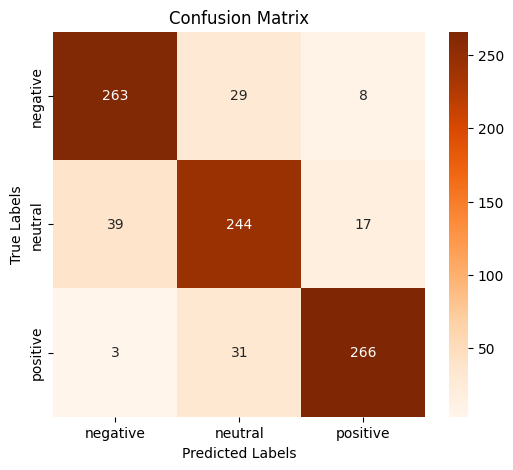

In [ ]:
evaluate(y_true, y_pred)


In [ ]:
!pip freeze > requirements.txt

In [5]:
from huggingface_hub import HfApi, upload_file, login
import os

login(token="---")
folder_path = "/content/drive/MyDrive/AI_Models"
repo_id = "azizdeniz890/Llama3-8B-Financial-Sentiment-LoRA"
files_to_upload = [
    "adapter_config.json",
    "adapter_model.safetensors",
    "requirements.txt",
    "special_tokens_map.json",
    "testft1.ipynb",
    "tokenizer.json",
    "tokenizer_config.json",
    "training_args.bin"
]
api = HfApi()

for file_name in files_to_upload:
    file_path = os.path.join(folder_path, file_name)
    if os.path.exists(file_path):
        upload_file(
            path_or_fileobj=file_path,
            path_in_repo=file_name,
            repo_id=repo_id,
            repo_type="model",
            commit_message=f"Upload {file_name}"
        )
        print(f"Yüklendi: {file_name}")
    else:
        print(f"HATA: Dosya bulunamadı → {file_path}")


Yüklendi: adapter_config.json


adapter_model.safetensors:   0%|          | 0.00/671M [00:00<?, ?B/s]

Yüklendi: adapter_model.safetensors
Yüklendi: requirements.txt
Yüklendi: special_tokens_map.json
Yüklendi: testft1.ipynb


tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

Yüklendi: tokenizer.json
Yüklendi: tokenizer_config.json


training_args.bin:   0%|          | 0.00/5.62k [00:00<?, ?B/s]

Yüklendi: training_args.bin


In [1]:
# Git kurulumunu doğrula (Colab'da genelde yüklüdür)
!git --version

# Gerekirse yeniden yapılandırmak için (sadece bir kere)
!git config --global user.name "Your Name"
!git config --global user.email "your.email@example.com"


git version 2.34.1


In [3]:
!apt-get install git -qq
!git config --global user.email "azizdeniz890@gmail.com"
!git config --global user.name "azizdeniz890"

In [5]:
!pip install PyGithub


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 30.8 MB/s eta 0:00:00


In [7]:
from github import Github

# GitHub Token'ını gir (GitHub'dan 'repo' izniyle bir token oluştur)
token = "---"  # ← buraya kendi token'ını yaz
g = Github(token)

# Yeni repo oluştur (özel veya herkese açık)
user = g.get_user()
repo = user.create_repo(
    name="Llama3-Financial-Sentiment-QLoRA",  # ← repo adı
    private=False,                  # True yaparsan özel olur
    description="Uploaded from Colab"
)

print("Repo oluşturuldu:", repo.html_url)


Repo oluşturuldu: https://github.com/azizdeniz890/Llama3-Financial-Sentiment-QLoRA
